In [112]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random

# Basic LSTM from tutorial

In [113]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [autograd.Variable(torch.randn((1, 3))) for _ in range(5)]  # make a sequence of length 5
print(inputs)
print("-------------------")
# initialize the hidden state.
hidden = (autograd.Variable(torch.randn(1, 1, 3)), autograd.Variable(torch.randn((1, 1, 3))))
print(hidden)
print("-------------------")
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)
print(out)
print(hidden)

[Variable containing:
-0.2275 -1.1062 -0.4056
[torch.FloatTensor of size 1x3]
, Variable containing:
 0.1310 -0.2171 -0.7024
[torch.FloatTensor of size 1x3]
, Variable containing:
 0.3482  0.9366 -0.2694
[torch.FloatTensor of size 1x3]
, Variable containing:
-2.0989  0.8756  1.1502
[torch.FloatTensor of size 1x3]
, Variable containing:
 0.4442 -0.7852  1.3552
[torch.FloatTensor of size 1x3]
]
-------------------
(Variable containing:
(0 ,.,.) = 
 -0.7264 -0.6403 -0.4487
[torch.FloatTensor of size 1x1x3]
, Variable containing:
(0 ,.,.) = 
 -0.6554  0.7576  1.7538
[torch.FloatTensor of size 1x1x3]
)
-------------------
Variable containing:
(0 ,.,.) = 
  0.0378  0.0332 -0.1123
[torch.FloatTensor of size 1x1x3]

(Variable containing:
(0 ,.,.) = 
  0.0378  0.0332 -0.1123
[torch.FloatTensor of size 1x1x3]
, Variable containing:
(0 ,.,.) = 
  0.0631  0.1178 -0.3186
[torch.FloatTensor of size 1x1x3]
)


In [114]:
inputs = [autograd.Variable(torch.randn((1, 3))) for _ in range(5)]  # make a sequence of length 5
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
# print(inputs)
# print("-------------------")
hidden = (autograd.Variable(torch.randn(1, 1, 3)), autograd.Variable(torch.randn((1, 1, 3))))  # clean out hidden state
# print(hidden)
# print("-------------------")
out, hidden = lstm(inputs, hidden)
print(out)
print("---------------------------------------")
print(hidden)

Variable containing:
(0 ,.,.) = 
  0.1831  0.1643 -0.5233

(1 ,.,.) = 
  0.2461 -0.0436 -0.3136

(2 ,.,.) = 
 -0.0793 -0.1841 -0.1556

(3 ,.,.) = 
  0.1875 -0.1087 -0.2551

(4 ,.,.) = 
  0.1812 -0.0302 -0.2254
[torch.FloatTensor of size 5x1x3]

---------------------------------------
(Variable containing:
(0 ,.,.) = 
  0.1812 -0.0302 -0.2254
[torch.FloatTensor of size 1x1x3]
, Variable containing:
(0 ,.,.) = 
  0.3162 -0.1519 -0.4503
[torch.FloatTensor of size 1x1x3]
)


# LSTM

In [115]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)

In [116]:
training_data = [
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
]
print("Training data: \n", training_data)

word_to_ix = {}
for sent, tags in training_data:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print("\nWord dict: \n", word_to_ix)

tag_to_ix = {"DET": 0, "NN": 1, "V": 2}

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

Training data: 
 [(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']), (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN'])]

Word dict: 
 {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8}


In [117]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [118]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
inputs = prepare_sequence(training_data[0][0], word_to_ix)
tag_scores = model(inputs)
print(tag_scores)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
#         print("Input: ", sentence)
#         print("Tags: ", tags)
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
#         print("Prep input: ", sentence_in)
        targets = prepare_sequence(tags, tag_to_ix)
#         print("Prep tag: ", targets)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
#         print("Scores: ", tag_scores)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()

# See what the scores are after training
inputs = prepare_sequence(['dog', 'dog', 'dog', 'dog', 'dog', 'dog',], word_to_ix)
tag_scores = model(inputs)
# The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
#  for word i. The predicted tag is the maximum scoring tag.
# Here, we can see the predicted sequence below is 0 1 2 0 1
# since 0 is index of the maximum value of row 1,
# 1 is the index of maximum value of row 2, etc.
# Which is DET NOUN VERB DET NOUN, the correct sequence!
print(tag_scores)

Variable containing:
-1.4350 -1.2465 -0.7458
-1.4579 -1.1735 -0.7809
-1.3504 -1.1555 -0.8534
-1.3558 -1.2744 -0.7708
-1.3321 -1.2605 -0.7928
[torch.FloatTensor of size 5x3]

Variable containing:
-5.4403 -0.0436 -3.2620
-5.9751 -0.0718 -2.7075
-6.1204 -0.0712 -2.7100
-6.1765 -0.0672 -2.7659
-6.2042 -0.0648 -2.8016
-6.2193 -0.0635 -2.8212
[torch.FloatTensor of size 6x3]



In [173]:
def create_dict(training_data):
    word_to_ix = {}
    for sent in training_data:
        for word in sent:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    print(word_to_ix)
    return word_to_ix
    
def create_data(sentences):
    training_data = []
    for s in sentences:
        for i in range(len(s)):
            training_data.append(s)
            s = np.roll(s,-1).tolist()
            
            
    print(training_data)
    return training_data

In [432]:
sentences = ["The dog ate the apple . \n".split(' '), 
             "One cat drank milk . \n".split(' '),
             "A bird flew up high . \n".split(' '),
             "The rat ate the bread . \n".split(' '), 
             "Two cows drank milk . \n".split(' '),
             "A turtle swam up high . \n".split(' '),
             "The lion ate a person . \n".split(' '), 
             "One bat drank blood . \n".split(' '),
             "A tiger jumped up high . \n".split(' '),
             "The mouse ate the cheese . \n".split(' '), 
             "Two sheep drank water . \n".split(' '),
             "A horse jumped up high . \n".split(' ')]

training_data = create_data(sentences)
word_to_ix = create_dict(training_data)

ix_to_word = dict([(y, x) for (y, x) in enumerate(word_to_ix)])
print(ix_to_word)

# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 6
HIDDEN_DIM = 6

[['The', 'dog', 'ate', 'the', 'apple', '.', '\n'], ['dog', 'ate', 'the', 'apple', '.', '\n', 'The'], ['ate', 'the', 'apple', '.', '\n', 'The', 'dog'], ['the', 'apple', '.', '\n', 'The', 'dog', 'ate'], ['apple', '.', '\n', 'The', 'dog', 'ate', 'the'], ['.', '\n', 'The', 'dog', 'ate', 'the', 'apple'], ['\n', 'The', 'dog', 'ate', 'the', 'apple', '.'], ['One', 'cat', 'drank', 'milk', '.', '\n'], ['cat', 'drank', 'milk', '.', '\n', 'One'], ['drank', 'milk', '.', '\n', 'One', 'cat'], ['milk', '.', '\n', 'One', 'cat', 'drank'], ['.', '\n', 'One', 'cat', 'drank', 'milk'], ['\n', 'One', 'cat', 'drank', 'milk', '.'], ['A', 'bird', 'flew', 'up', 'high', '.', '\n'], ['bird', 'flew', 'up', 'high', '.', '\n', 'A'], ['flew', 'up', 'high', '.', '\n', 'A', 'bird'], ['up', 'high', '.', '\n', 'A', 'bird', 'flew'], ['high', '.', '\n', 'A', 'bird', 'flew', 'up'], ['.', '\n', 'A', 'bird', 'flew', 'up', 'high'], ['\n', 'A', 'bird', 'flew', 'up', 'high', '.'], ['The', 'rat', 'ate', 'the', 'bread', '.', '\n'],

In [469]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(word_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


loss_save = []
for epoch in range(400):  # again, normally you would NOT do 300 epochs, it is toy data
    training_data = random.sample(training_data, len(training_data))
    for sentence in training_data:
        tags = np.roll(sentence,-1).tolist()

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Variables of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
#         print("Prep input: ", sentence_in)
        targets = prepare_sequence(tags, word_to_ix)
#         print("Prep tag: ", targets)
        
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
#         print("Scores: ", tag_scores)
        
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        loss_save.append(loss.data)
        optimizer.step()

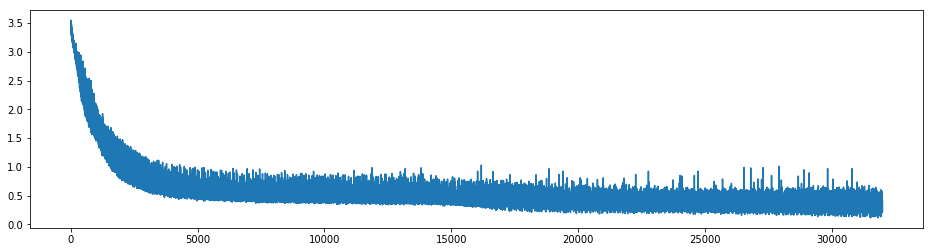

In [470]:
import matplotlib.pyplot as plt

plt.figure(figsize = [16,4])
plt.plot(loss_save, '-', ms=3)
plt.show()

In [480]:
input_word = '.'
print(input_word, end=' ')

for i in range(50):
    inputs = prepare_sequence([input_word], word_to_ix)
    
    model.hidden = model.init_hidden()
    tag_scores = model(inputs)
    
    input_word = ix_to_word[int(tag_scores.max(dim=1)[1])]
    print(input_word, end=' ')

. 
 The rat ate the bread . 
 The rat ate the bread . 
 The rat ate the bread . 
 The rat ate the bread . 
 The rat ate the bread . 
 The rat ate the bread . 
 The rat ate the bread . 
 